In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import numpy as np

from scipy.stats import t, ttest_1samp

## loading and cleaning data

In [2]:
data=pd.read_csv('QVI_data.csv')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
data.nunique()

LYLTY_CARD_NBR       72636
DATE                   364
STORE_NBR              272
TXN_ID              263125
PROD_NBR               114
PROD_NAME              114
PROD_QTY                 5
TOT_SALES              111
PACK_SIZE               21
BRAND                   21
LIFESTAGE                7
PREMIUM_CUSTOMER         3
dtype: int64

In [5]:
#converting data types
data['DATE']=pd.to_datetime(data['DATE'])
for col in ['LYLTY_CARD_NBR','STORE_NBR','TXN_ID','PROD_NBR']:
    data[col]=data[col].astype('object')

In [6]:
#adding new date column with only year and month
data['YEAR_MONTH'] = data['DATE'].apply(lambda x: x.strftime('%Y%m')) 

In [7]:
#Dropping stores those do not have sales every month over July 2018 to June 2019
failed_store1=data.groupby(['STORE_NBR','YEAR_MONTH'])['TOT_SALES'].count().reset_index().drop('TOT_SALES',axis=1) 
failed_store2=failed_store1.groupby('STORE_NBR')['YEAR_MONTH'].count().reset_index() 
failed_store_nbr = failed_store2['STORE_NBR'].loc[failed_store2.YEAR_MONTH != 12].to_list()
failed_store_nbr

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [8]:
data=data[~data.isin({'STORE_NBR':failed_store_nbr})]
idx=pd.IndexSlice
data=data.groupby(['STORE_NBR','YEAR_MONTH']).agg({'TOT_SALES':'sum','LYLTY_CARD_NBR':'nunique'})
data=data.rename(columns={'TOT_SALES':'REVENUE','LYLTY_CARD_NBR':'CUST_NBR'})
data

REVENUE  CUST_NBR
STORE_NBR YEAR_MONTH                   
1         201807        206.9        49
          201808        176.1        42
          201809        278.8        59
          201810        188.1        44
          201811        192.6        46
...                       ...       ...
272       201902        395.5        45
          201903        442.3        50
          201904        445.1        54
          201905        314.6        34
          201906        312.1        34

[3120 rows x 2 columns]

In [9]:
pretrial_data=data.loc[idx[:,'201807':'201901'],:]
pretrial_data

REVENUE  CUST_NBR
STORE_NBR YEAR_MONTH                   
1         201807        206.9        49
          201808        176.1        42
          201809        278.8        59
          201810        188.1        44
          201811        192.6        46
...                       ...       ...
272       201809        304.7        32
          201810        430.6        44
          201811        376.2        41
          201812        403.9        47
          201901        423.0        46

[1820 rows x 2 columns]

## calculating metrics

### finding control stores for trial stores

In [10]:
trial_store_nbr=[77,86,88]
comparison_store_nbr=pretrial_data.index.levels[0].drop(labels=trial_store_nbr).tolist()

In [11]:
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

#define a function to caculate correlation and distance 
def calc_corr(trail_store_nbr):
    corrTable=pd.DataFrame()
    scaler=MinMaxScaler()
    for i in comparison_store_nbr:   
        corrTable=corrTable.append({
                'compare_store': i,
                'revenue_corr':pretrial_data.loc[idx[trail_store_nbr],:].corrwith(pretrial_data.loc[idx[i],:])['REVENUE'],
                'customer_corr':pretrial_data.loc[idx[trail_store_nbr],:].corrwith(pretrial_data.loc[idx[i],:],method='pearson')['CUST_NBR'],
                'revenue_distance':distance.euclidean(pretrial_data.loc[idx[trail_store_nbr],['REVENUE']],pretrial_data.loc[idx[i],['REVENUE']]),
                'customer_distance':distance.euclidean(pretrial_data.loc[idx[trail_store_nbr],['CUST_NBR']],pretrial_data.loc[idx[i],['CUST_NBR']])   
            },ignore_index=True)
        corrTable['compare_store']=corrTable['compare_store'].astype(int)
        scaled_distance=scaler.fit_transform(corrTable[['revenue_distance','customer_distance']])
        corrTable['scaled_revenue_distance']=scaled_distance[:,0]
        corrTable['scaled_customer_distance']=scaled_distance[:,1]
        corrTable['score_revenue']=(1-corrTable['scaled_revenue_distance'])*0.5+corrTable['revenue_corr']*0.5
        corrTable['score_customer']=(1-corrTable['scaled_customer_distance'])*0.5+corrTable['customer_corr']*0.5 
        corrTable['average_score']=(corrTable['score_revenue']+corrTable['score_customer'])*0.5                              
                                     
    return corrTable.nlargest(1,'average_score')[['compare_store','average_score']]

In [12]:
for s in trial_store_nbr:
    print(f'\n-----------------------------------------------------')
    print('Top potential control store for trial store %i is %i' %(s,calc_corr(s)['compare_store'].item()))


-----------------------------------------------------
Top potential control store for trial store 77 is 233

-----------------------------------------------------
Top potential control store for trial store 86 is 155

-----------------------------------------------------
Top potential control store for trial store 88 is 237


### Visulaizing the result 

In [13]:
style.use('seaborn-poster')
sns.set_style('darkgrid')

def visulization_trial_control(trial,control):
    fig,(ax1,ax2)=plt.subplots(1,2)
    
    x=pretrial_data.index.get_level_values('YEAR_MONTH').unique()
    y1=pretrial_data.loc[idx[trial],['REVENUE']]
    y2=pretrial_data.loc[idx[control],['REVENUE']]
    
    ax1.plot(x,y1,label="trial store %i" %(trial))
    ax1.legend(loc=9)
    ax1.plot(x,y2,label="control store %i" %(control))
    ax1.legend(loc=9)
    ax1.set_title("Monthly Revenue")
    
    y3=pretrial_data.loc[idx[trial],['CUST_NBR']]
    y4=pretrial_data.loc[idx[control],['CUST_NBR']]
     
    ax2.plot(x,y3,label="trial store %i" %(trial))
    ax2.legend(loc=9)
    ax2.plot(x,y4,label="control store %i" %(control))
    ax2.legend(loc=9) 
    ax2.set_title('Monthly Number of Customers')
    
    fig.suptitle('trial store %s and control store %s comparison befor trial' %(trial,control),fontsize=25)
    ax1.xaxis.set_tick_params(rotation=45)
    ax2.xaxis.set_tick_params(rotation=45)

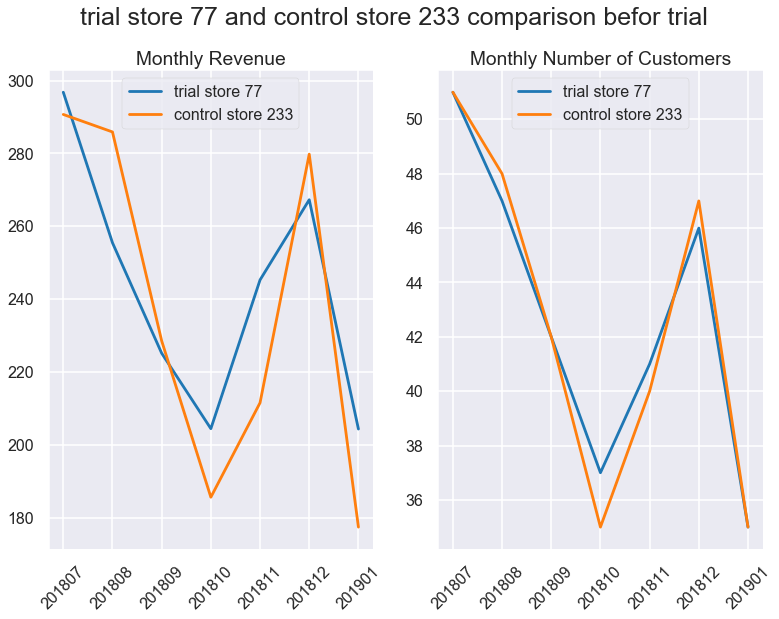

In [14]:
visulization_trial_control(77,233)

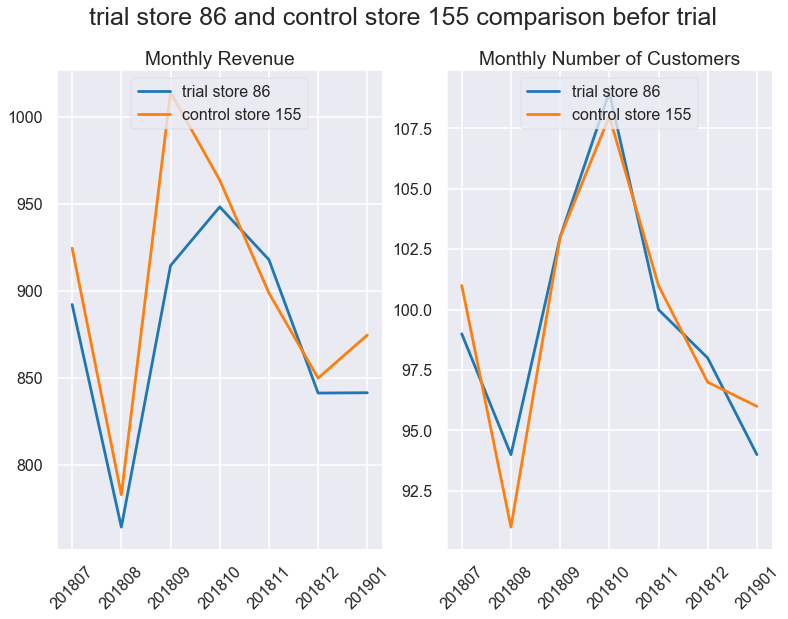

In [15]:
visulization_trial_control(86,155)

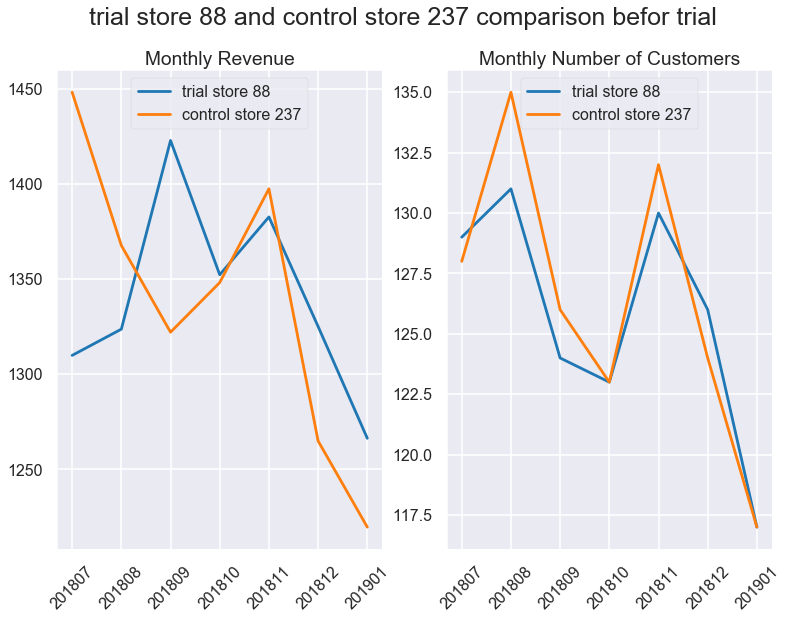

In [16]:
visulization_trial_control(88,237)

## Assesment
The trial goes from Feb 2019 to Apr 2019. We now asses if there have been uplifts in overall monthly revenue and number of customers

### Use t test to evaluate performace difference between trial stores and control stores duing trial period

**Null Hypothesis: There is no difference between trial and control stores during the trial period (H0 : pct_diff = 0)**

**Alternative Hypothesis: There is difference between trial and control stores during the trial period (HA : pct_diff != 0)**

**Use critical value approach to compare the test statistic to the critical value. If the test statistic is more extreme in the direction of the alternative than the critical value, reject the null hypothesis in favor of the alternative hypothesis. If the test statistic is less extreme than the critical value, do not reject the null hypothesis.

In [29]:
def assestment_trial_control(trial,control):
    #scale control store's sales to match trial store's sales prior to the trial period  
    trial_sum_revenue=pretrial_data.loc[idx[trial],'REVENUE'].sum()
    control_sum_revenue=pretrial_data.loc[idx[control],'REVENUE'].sum()
    scaling_factor_revenue=trial_sum_revenue/control_sum_revenue

    #scale control store's customer numbers to match trial store's customer numbers prior to the trial period
    trial_sum_cust=pretrial_data.loc[idx[trial],'CUST_NBR'].sum()
    control_sum_cust=pretrial_data.loc[idx[control],'CUST_NBR'].sum()
    scaling_factor_cust=trial_sum_cust/control_sum_cust

    pd.set_option('display.width', 150)

    assesTable=pd.DataFrame(data.loc[idx[trial],'REVENUE']).rename(columns={'REVENUE':f'REVENUE_{trial}'})
    #apply the scaling factor to have comparable sales figure for control store
    assesTable[f'SCALED_REVENUE_{control}']=data.loc[idx[control],'REVENUE']*scaling_factor_revenue  
    #calcuate the percentage difference in revenue
    assesTable['PCT_DIFF_REVENUE']=abs(assesTable[f'SCALED_REVENUE_{control}']-assesTable[f'REVENUE_{trial}'])/assesTable[f'SCALED_REVENUE_{control}']

    assesTable[f'CUST_NBR_{trial}']=data.loc[idx[trial],'CUST_NBR']
    #apply the scaling factor to have comparable customer numbers figure for control store
    assesTable[f'SCALED_CUST_NBR_{control}']=data.loc[idx[control],'CUST_NBR']*scaling_factor_cust   
    #calcuate the percentage difference in customer numbers
    assesTable['PCT_DIFF_CUST']=abs(assesTable[f'SCALED_CUST_NBR_{control}']-assesTable[f'CUST_NBR_{trial}'])/assesTable[f'SCALED_CUST_NBR_{control}']

    print('Percentage differences in revenue and number of customers by month between trial store %s and control store %s' %(trial,control))
    print("\n")
    print(assesTable)
    print("\n")

    fig,(ax1,ax2)=plt.subplots(2,1)
    x=data.index.levels[1]
    y1=data.loc[idx[trial],['REVENUE']]
    y2=data.loc[idx[control],['REVENUE']]
    
    ax1.plot(x,y1,label="trial store %i" %(trial))
    ax1.legend(loc=9)
    ax1.plot(x,y2,label="control store %i" %(control))
    ax1.legend(loc=9)
    ax1.set_title("Monthly Revenue")
    ax1.axvspan(7,9,facecolor='g', alpha=0.2)
    
    y3=data.loc[idx[trial],['CUST_NBR']]
    y4=data.loc[idx[control],['CUST_NBR']]
     
    ax2.plot(x,y3,label="trial store %i" %(trial))
    ax2.legend(loc=9)
    ax2.plot(x,y4,label="control store %i" %(control))
    ax2.legend(loc=9) 
    ax2.set_title('Monthly Number of Customers')
    ax2.axvspan(7,9,facecolor='g', alpha=0.2)
    
    fig.suptitle('trial store %s and control store %s comparison during trial period' %(trial,control),y=1.03,fontsize=25)
    
    fig.tight_layout()
    plt.show()
    
    #there is 8 months in the pre-trial period, hence degree of freedom is 7 
    #find the 95th percentile of the t distribution with the appropriate degrees of freedom to compare against
    t_critial=t.ppf(q=0.95,df=7)
    print('The 95th percentitle value of the t-distribution:',t_critial)
    print("\n")
    
    #caculate standard deviation
    std_revenue=assesTable['PCT_DIFF_REVENUE'][:7].std()
    std_cust=assesTable['PCT_DIFF_CUST'][:7].std()

    #test with null hypothesis of there being 0 differnece between trial and control stores
    print('t-value for total sales in trial period:')
    print(assesTable['PCT_DIFF_REVENUE'][7:10]/std_revenue)
    print("\n")
    print('t-value for number of customers in trial period:')
    print(assesTable['PCT_DIFF_CUST'][7:10]/std_cust)

Percentage differences in revenue and number of customers by month between trial store 77 and control store 233


            REVENUE_77  SCALED_REVENUE_233  PCT_DIFF_REVENUE  CUST_NBR_77  SCALED_CUST_NBR_233  PCT_DIFF_CUST
YEAR_MONTH                                                                                                   
201807           296.8          297.565550          0.002573           51            51.171141       0.003344
201808           255.5          292.652187          0.126950           47            48.161074       0.024108
201809           225.2          233.998916          0.037602           42            42.140940       0.003344
201810           204.5          190.085733          0.075830           37            35.117450       0.053607
201811           245.3          216.597421          0.132516           41            40.134228       0.021572
201812           267.3          286.408121          0.066716           46            47.157718       0.024550
201901

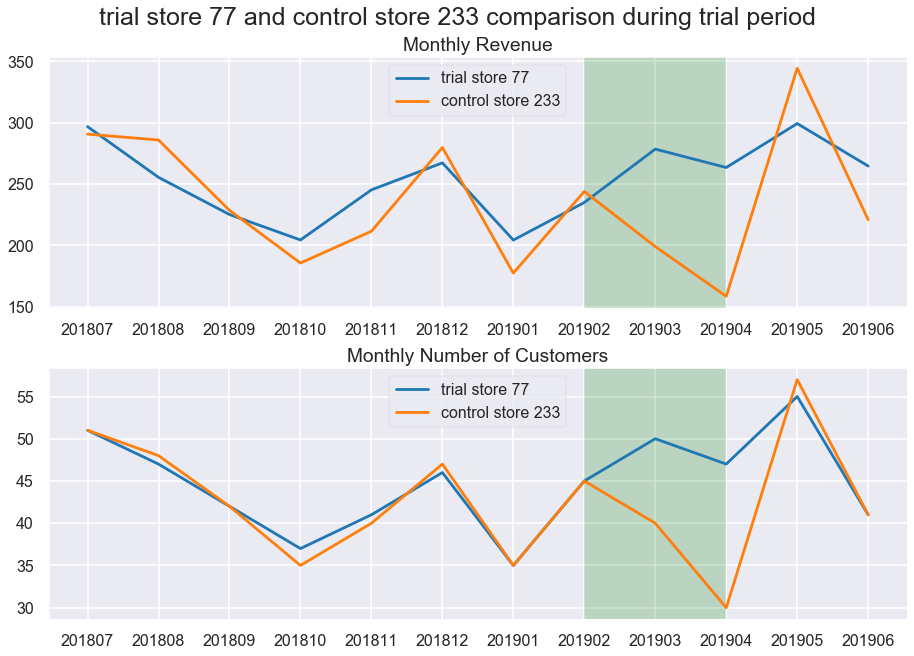

The 95th percentitle value of the t-distribution: 1.894578605061305


t-value for total sales in trial period:
YEAR_MONTH
201902     1.183534
201903     7.339116
201904    12.476373
Name: PCT_DIFF_REVENUE, dtype: float64


t-value for number of customers in trial period:
YEAR_MONTH
201902     0.183352
201903    13.476388
201904    30.778725
Name: PCT_DIFF_CUST, dtype: float64


In [30]:
assestment_trial_control(77,233)

**The results show that t-value is much larger than the 95th percentile value of the t-distribution for March and April. The trial in store 77 is significantly different to its control store in two of the three trial months.**

Percentage differences in revenue and number of customers by month between trial store 86 and control store 155


            REVENUE_86  SCALED_REVENUE_155  PCT_DIFF_REVENUE  CUST_NBR_86  SCALED_CUST_NBR_155  PCT_DIFF_CUST
YEAR_MONTH                                                                                                   
201807          892.20          896.922236          0.005265           99                101.0       0.019802
201808          764.05          759.269991          0.006296           94                 91.0       0.032967
201809          914.60          984.034086          0.070561          103                103.0       0.000000
201810          948.40          934.948790          0.014387          109                108.0       0.009259
201811          918.00          871.894555          0.052880          100                101.0       0.009901
201812          841.20          824.361363          0.020426           98                 97.0       0.010309
201901

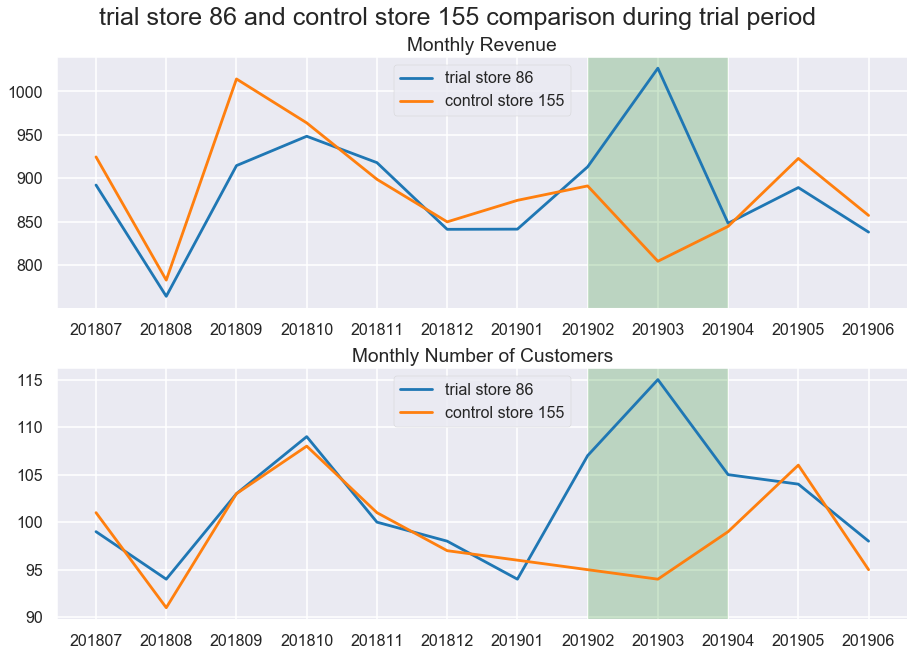

The 95th percentitle value of the t-distribution: 1.894578605061305


t-value for total sales in trial period:
YEAR_MONTH
201902     2.179542
201903    12.226922
201904     1.364580
Name: PCT_DIFF_REVENUE, dtype: float64


t-value for number of customers in trial period:
YEAR_MONTH
201902    11.819082
201903    20.903430
201904     5.670772
Name: PCT_DIFF_CUST, dtype: float64


In [31]:
assestment_trial_control(86,155)

**As we saw, in trial store 86, sales were not signigicantly higher, but the number of customers is signigicantly higher in all of three months. **

Percentage differences in revenue and number of customers by month between trial store 88 and control store 237


            REVENUE_88  SCALED_REVENUE_237  PCT_DIFF_REVENUE  CUST_NBR_88  SCALED_CUST_NBR_237  PCT_DIFF_CUST
YEAR_MONTH                                                                                                   
201807         1310.00         1450.657086          0.096961          129           127.276836       0.013539
201808         1323.80         1369.931485          0.033674          131           134.237288       0.024116
201809         1423.00         1324.260425          0.074562          124           125.288136       0.010281
201810         1352.40         1350.401097          0.001480          123           122.305085       0.005682
201811         1382.80         1399.777923          0.012129          130           131.254237       0.009556
201812         1325.20         1266.971288          0.045959          126           123.299435       0.021902
201901

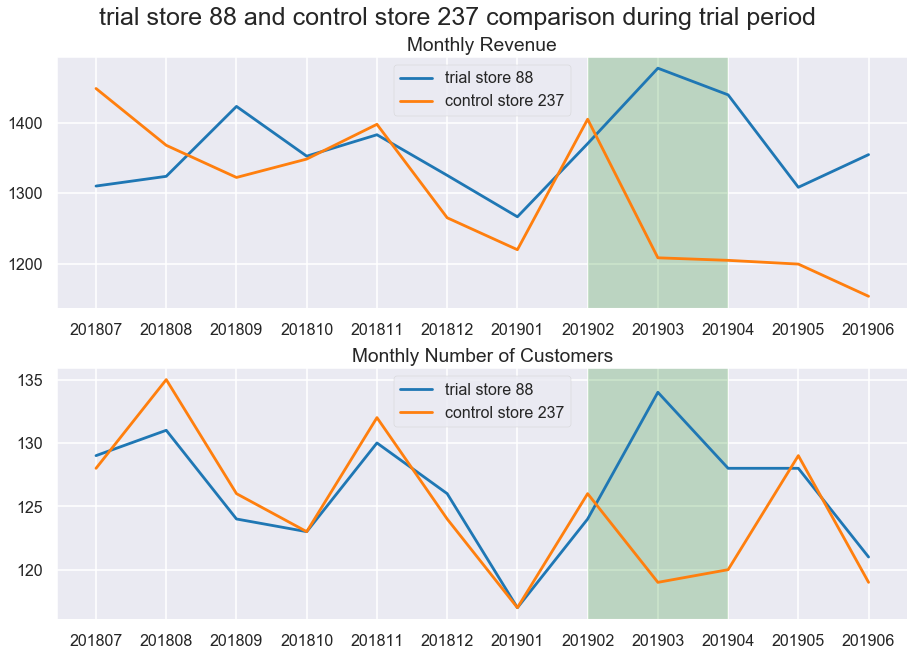

The 95th percentitle value of the t-distribution: 1.894578605061305


t-value for total sales in trial period:
YEAR_MONTH
201902    0.781270
201903    6.595668
201904    5.768527
Name: PCT_DIFF_REVENUE, dtype: float64


t-value for number of customers in trial period:
YEAR_MONTH
201902     1.387456
201903    17.873693
201904     9.814423
Name: PCT_DIFF_CUST, dtype: float64


In [32]:
assestment_trial_control(88,237)

**Both sales and number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a postitive trial effect. **

### Conclusion
The results for trial stores 77 and 88  during the trial period show a significant difference in at least two of the tree trial months but this is not the case for trial store 86. We can check with the client if the implementation of the trial was different in trial store 86. But overrall, the trial shows a siginicant increase in both sales and number of customers. 
